In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import json
from pathlib import Path
import pandas as pd
import numpy as np

import seaborn as sns
sns.set_theme(style="darkgrid")

logdir = Path("/bigdata/cifar10/logs/decomposed")
import os
from datetime import datetime
from os.path import isdir

folders = os.listdir(logdir)
print(f"number of folders: {len(folders)}")
# from datetime import datetime

# dts = [datetime.fromtimestamp(int(x)) for x in folders]
# print(max(dts))
# print(min(dts))
from tddl.post_processing.path_utils import logdir_to_paths

paths = logdir_to_paths(logdir)

print(len(paths))
# baseline

baseline_path = Path("/bigdata/cifar10/logs/baselines/1646668631/rn18_18_dNone_128_adam_l0.001_g0.1_w0.0_sTrue")
# baseline_model = torch.load(baseline_path / "cnn_best.pth")
with open(baseline_path/'results.json') as json_file:
    baseline_result = json.load(json_file)
baseline_result
from tddl.post_processing.factorized_model import process_factorized_networks

# process_factorized_networks(paths, baseline_path)
from tddl.post_processing.path_utils import paths_to_df

df = paths_to_df(paths)
print(len(df))
df.head()

# df.groupby('rank').count()
# rank=0.90: 10 observations
# rank=0.75: 10 observstions

# Exclude the few observations (layer=28, decomp={cp,tucker}) where rank is 0.75 or 0.90

df = df[~df['rank'].isin(['0.75', '0.90'])]
df['test_error'] = 1 - df.test_acc
df['valid_error_before_ft'] = 1 - df.valid_acc_before_ft
df['valid_error'] = 1 - df.valid_acc

df['log_test_error'] = np.log(df.test_error)
df['log_valid_error_before_ft'] = np.log(df.valid_error_before_ft)
df['log_valid_error'] = np.log(df.valid_error)
df['rank'] = df['rank'].astype(float, copy=False)
# df['rank'].apply(float)
df['rank'].unique()
df['fact_rank'] = df['factorization'] + '-' + df['rank'].apply(str)
df['fact_layers'] = df['factorization'] + '-' + df['layers'].apply(str)
df['layers_fact'] = df['layers'].apply(str) + '-' + df['factorization'] 
df.head()
df = df.astype({
    'layers':"category",
    'fact_layers':"category",
    'layers_fact':"category",
})

number of folders: 381
380
380


/home/jetzeschuurman/gitProjects/phd/tltorch/tltorch/factorized_tensors/core.py:145: UserWarning: Creating a subclass of FactorizedTensor TensorizedTensor with no name.
  warnings.warn(f'Creating a subclass of FactorizedTensor {cls.__name__} with no name.')


In [3]:
import statsmodels.api as sm
import pandas as pd
from patsy import dmatrices
import numpy as np

In [4]:
df.columns

Index(['name', 'nr', 'relative_norm_weight', 'scaled_norm_weight',
       'diff_norm_weight', 'layers', 'factorization', 'rank', 'valid_acc',
       'valid_acc_before_ft', 'test_acc_before_ft', 'n_param_fact', 'test_acc',
       'lr', 'optimizer', 'norm_diff', 'norm_b', 'n_b', 'relative_norm',
       'scaled_norm', 'test_error', 'valid_error_before_ft', 'valid_error',
       'log_test_error', 'log_valid_error_before_ft', 'log_valid_error',
       'fact_rank', 'fact_layers', 'layers_fact'],
      dtype='object')

In [5]:
y, X = dmatrices('log_test_error ~ factorization + factorization:relative_norm_weight + relative_norm_weight', data=df, return_type='dataframe')

In [6]:
X

,Intercept,factorization[T.tt],factorization[T.tucker],relative_norm_weight,factorization[T.tt]:relative_norm_weight,factorization[T.tucker]:relative_norm_weight
0,1.0,0.0,0.0,0.311843,0.000000,0.000000
1,1.0,0.0,1.0,0.337100,0.000000,0.337100
2,1.0,0.0,1.0,0.272814,0.000000,0.272814
3,1.0,0.0,1.0,0.823151,0.000000,0.823151
5,1.0,0.0,1.0,0.198279,0.000000,0.198279
...,...,...,...,...,...,...
375,1.0,0.0,1.0,0.452808,0.000000,0.452808
376,1.0,1.0,0.0,0.785133,0.785133,0.000000
377,1.0,1.0,0.0,0.820082,0.820082,0.000000
378,1.0,0.0,1.0,0.798234,0.000000,0.798234


In [7]:
df.nr

0      63
1      60
2      60
3      28
5      63
       ..
375    38
376    15
377    28
378    15
379    44
Name: nr, Length: 360, dtype: int64

In [8]:
res = sm.OLS(y, X).fit()
print(res.summary())


                            OLS Regression Results                            
Dep. Variable:         log_test_error   R-squared:                       0.453
Model:                            OLS   Adj. R-squared:                  0.445
Method:                 Least Squares   F-statistic:                     58.52
Date:                Wed, 24 Aug 2022   Prob (F-statistic):           2.72e-44
Time:                        10:23:01   Log-Likelihood:                 541.16
No. Observations:                 360   AIC:                            -1070.
Df Residuals:                     354   BIC:                            -1047.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                                   coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------

In [9]:
R = [
    # [0, 1, 0, 0, 0, 0,],
    [0, 0, 1, 0, 0, 0,],
    # [0, 0, 0, 0, 1, 0,],
    [0, 0, 0, 0, 0, 1,],
]
res.f_test(R)

<class 'statsmodels.stats.contrast.ContrastResults'>
<F test: F=1.5948527735062186, p=0.20439304237230996, df_denom=354, df_num=2>

In [10]:
layers = [15,19,28,38,41,44,60,63]
R = [
    [0, 1, 0, 0, 0, 0,],
    [0, 0, 1, 0, 0, 0,],
    [0, 0, 0, 0, 1, 0,],
    [0, 0, 0, 0, 0, 1,],
]
p_values = np.zeros((len(layers),))
# print(layers)
for i,l in enumerate(layers):
    print(l)
    df_ = df[df.nr == l]
    y, X = dmatrices('log_test_error ~ factorization + factorization:relative_norm_weight + relative_norm_weight', data=df_, return_type='dataframe')

    res = sm.OLS(y, X).fit()
    f = res.f_test(R)
    print(f)
    p_values[i] = f.pvalue

df_p = pd.DataFrame(columns=layers, index=['p-values'],data=p_values[None,:])
print(df_p.to_latex())

15
<F test: F=41.24144297014173, p=1.636676308761214e-13, df_denom=39, df_num=4>
19
<F test: F=21.398499640261676, p=2.0980364657828464e-09, df_denom=39, df_num=4>
28
<F test: F=29.104343196113604, p=3.0537263847174184e-11, df_denom=39, df_num=4>
38
<F test: F=29.693195509954084, p=2.288095185340534e-11, df_denom=39, df_num=4>
41
<F test: F=13.173396157769217, p=7.026292284927733e-07, df_denom=39, df_num=4>
44
<F test: F=8.521116103465642, p=4.8444476706790496e-05, df_denom=39, df_num=4>
60
<F test: F=0.7771928986872364, p=0.5467875565850567, df_denom=39, df_num=4>
63
<F test: F=0.1351543031342226, p=0.9684039593644403, df_denom=39, df_num=4>
\begin{tabular}{lrrrrrrrr}
\toprule
{} &            15 &            19 &            28 &            38 &            41 &        44 &        60 &        63 \\
\midrule
p-values &  1.636676e-13 &  2.098036e-09 &  3.053726e-11 &  2.288095e-11 &  7.026292e-07 &  0.000048 &  0.546788 &  0.968404 \\
\bottomrule
\end{tabular}



In [11]:
layers = [15,19,28,38,41,44,60,63]
R = [
    # [0, 1, 0, 0, 0, 0,],
    [0, 0, 1, 0, 0, 0,],
    # [0, 0, 0, 0, 1, 0,],
    [0, 0, 0, 0, 0, 1,],
]
p_values = np.zeros((len(layers),))
# print(layers)
for i,l in enumerate(layers):
    df_ = df[df.nr == l]
    y, X = dmatrices('log_test_error ~ factorization + factorization:relative_norm_weight + relative_norm_weight', data=df_, return_type='dataframe')

    res = sm.OLS(y, X).fit()
    f = res.f_test(R)
    print(f)
    p_values[i] = f.pvalue

df_p = pd.DataFrame(columns=layers, index=['p-values'],data=p_values[None,:])
print(df_p.to_latex())

<F test: F=12.703628282199059, p=5.6432751142501745e-05, df_denom=39, df_num=2>
<F test: F=6.1764219883312625, p=0.004674682088528634, df_denom=39, df_num=2>
<F test: F=4.656518109864026, p=0.01536403802955777, df_denom=39, df_num=2>
<F test: F=1.0096998524864487, p=0.3736530043925349, df_denom=39, df_num=2>
<F test: F=1.5538689419329674, p=0.22423457392610277, df_denom=39, df_num=2>
<F test: F=1.147926495614502, p=0.32778134606584153, df_denom=39, df_num=2>
<F test: F=1.2990606558602762, p=0.28432978288306393, df_denom=39, df_num=2>
<F test: F=0.0645584519553142, p=0.9375812851525049, df_denom=39, df_num=2>
\begin{tabular}{lrrrrrrrr}
\toprule
{} &        15 &        19 &        28 &        38 &        41 &        44 &       60 &        63 \\
\midrule
p-values &  0.000056 &  0.004675 &  0.015364 &  0.373653 &  0.224235 &  0.327781 &  0.28433 &  0.937581 \\
\bottomrule
\end{tabular}



In [12]:
replacements = {
    'valid_acc_before_ft': "Validation accuracy before fine-tuning", 
    'valid_acc': "Validation accuracy after fine-tuning",
    'test_acc': "Test accuracy after fine-tuning", 
    'relative_norm_weight': 'Relative Weights',
    'scaled_norm_weight': 'Scaled Weights',
    'diff_norm_weight': 'Absolute Weights',
    'relative_norm': 'Relative Features',
    'scaled_norm': 'Scaled Features',
    'norm_diff': 'Absolute Features',
    'log_valid_error_before_ft': 'Log Validation error before fine-tuning',
    'log_valid_error': 'Log Validation error after fine-tuning',
    'log_test_error': 'Log Test error after fine-tuning',
    'valid_error_before_ft': 'Validation error before fine-tuning',
    'valid_error': 'Validation error after fine-tuning',
    'test_error': 'Test error after fine-tuning'
    # 'log_norm_diff': 'Log absolute norm between training features',
}

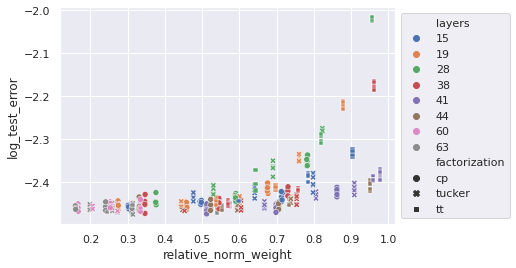

In [13]:
import seaborn as sns
ax = sns.scatterplot(data=df, x='relative_norm_weight', y='log_test_error', hue='layers', style='factorization')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [14]:
# plot the different linear estimates of layer 15 for CP, Tucker, TT

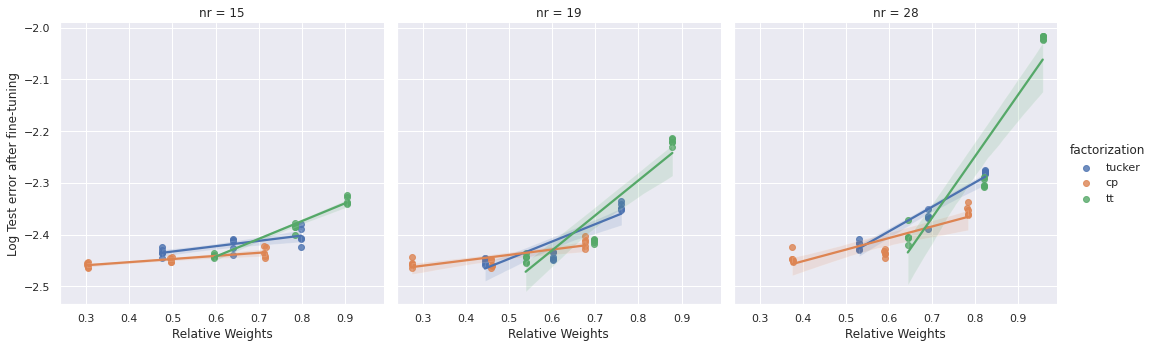

In [15]:
df_ltd = df[df.nr.isin([15, 19, 28])]
g = sns.lmplot(data=df_ltd, x='relative_norm_weight', y='log_test_error', hue='factorization', col='nr')
# ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
i = 0
for j in range(3):
        gax = g.axes[i][j]
        xlabel = gax.get_xlabel()
        ylabel = gax.get_ylabel()
        if xlabel in replacements.keys():
            g.axes[i][j].set_xlabel(replacements[xlabel])
        if ylabel in replacements.keys():
            g.axes[i][j].set_ylabel(replacements[ylabel])
g.savefig('/home/jetzeschuurman/gitProjects/phd/tddl/plots/cifar10/rn18/lm_layer_factorization')


In [67]:
1-np.exp(-2.45)

0.9137064135006295

In [16]:
df_ltd.columns

Index(['name', 'nr', 'relative_norm_weight', 'scaled_norm_weight',
       'diff_norm_weight', 'layers', 'factorization', 'rank', 'valid_acc',
       'valid_acc_before_ft', 'test_acc_before_ft', 'n_param_fact', 'test_acc',
       'lr', 'optimizer', 'norm_diff', 'norm_b', 'n_b', 'relative_norm',
       'scaled_norm', 'test_error', 'valid_error_before_ft', 'valid_error',
       'log_test_error', 'log_valid_error_before_ft', 'log_valid_error',
       'fact_rank', 'fact_layers', 'layers_fact'],
      dtype='object')

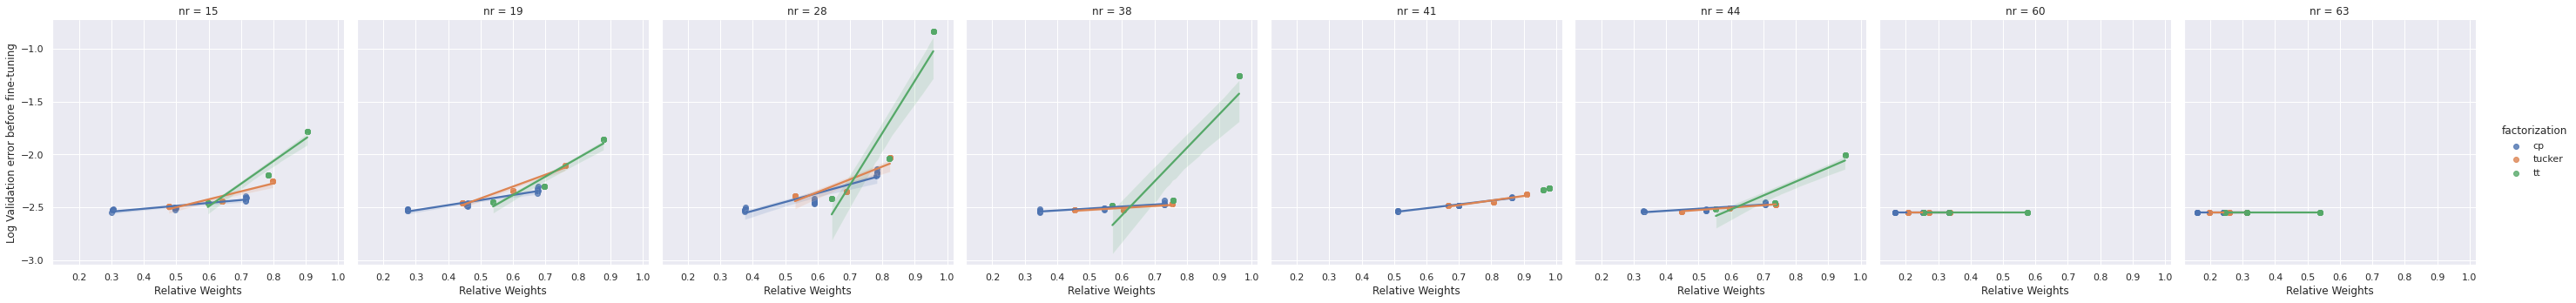

In [18]:
layer_idx = [15, 19, 28, 38, 41, 44, 60, 63]
df_ltd = df[df.nr.isin(layer_idx)]
g = sns.lmplot(data=df_ltd, x='relative_norm_weight', y='log_valid_error_before_ft', hue='factorization', col='nr')
# ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
i = 0
for j in range(len(layer_idx)):
        gax = g.axes[i][j]
        xlabel = gax.get_xlabel()
        ylabel = gax.get_ylabel()
        if xlabel in replacements.keys():
            g.axes[i][j].set_xlabel(replacements[xlabel])
        if ylabel in replacements.keys():
            g.axes[i][j].set_ylabel(replacements[ylabel])
# g.savefig('/home/jetzeschuurman/gitProjects/phd/tddl/plots/cifar10/rn18/lm_layer_factorization')

In [19]:
layers = [15,19,28,38,41,44,60,63]
R = [
    # [0, 1, 0, 0, 0, 0,],
    [0, 0, 1, 0, 0, 0,],
    # [0, 0, 0, 0, 1, 0,],
    [0, 0, 0, 0, 0, 1,],
]
p_values = np.zeros((len(layers),))
# print(layers)
for i,l in enumerate(layers):
    df_ = df[df.nr == l]
    y, X = dmatrices('log_valid_error_before_ft ~ factorization + factorization:relative_norm_weight + relative_norm_weight', data=df_, return_type='dataframe')

    res = sm.OLS(y, X).fit()
    f = res.f_test(R)
    print(f)
    p_values[i] = f.pvalue

df_p = pd.DataFrame(columns=layers, index=['p-values'],data=p_values[None,:])
print(df_p.to_latex())

<F test: F=9.876889726456987, p=0.00033850225604350705, df_denom=39, df_num=2>
<F test: F=3.084132877461505, p=0.05708318855723117, df_denom=39, df_num=2>
<F test: F=3.8799252380085085, p=0.029055885733728762, df_denom=39, df_num=2>
<F test: F=0.2768606002463827, p=0.7596377703831447, df_denom=39, df_num=2>
<F test: F=2.850167468441254, p=0.06963252860002377, df_denom=40, df_num=2>
<F test: F=1.4415750388747985, p=0.24888157474039024, df_denom=39, df_num=2>
<F test: F=0.18497113507518906, p=0.8318531522533512, df_denom=39, df_num=2>
<F test: F=0.3530098577436997, p=0.7047919518037603, df_denom=39, df_num=2>
\begin{tabular}{lrrrrrrrr}
\toprule
{} &        15 &        19 &        28 &        38 &        41 &        44 &        60 &        63 \\
\midrule
p-values &  0.000339 &  0.057083 &  0.029056 &  0.759638 &  0.069633 &  0.248882 &  0.831853 &  0.704792 \\
\bottomrule
\end{tabular}

